# Prepare

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import ConfusionMatrixDisplay
import os
import importlib
import sys
sys.path.append('./')
import NAB_scorer
importlib.reload(NAB_scorer)
from NAB_scorer import NABScorer

In [3]:
def plot_anomaly_scores(data, title, windows, threshold, labels):
    fig, ax1 = plt.subplots(figsize=(18, 6))
    # Ensure data.index is a pandas DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
        
    # Plot Oil Pressure and Pump Operation on the left y-axis
    ax1.plot(data.index, data['oil_pressure_u2'], label='Oil Pressure', color='b', alpha=0.8)
    ax1.plot(data.index, data['oil_pump_u2'].apply(lambda x: 100 if x == 1 else x), label='Pump Operation', color='g', linestyle='--', alpha=0.8)
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot Anomaly Score on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['anomaly_score'], label='Anomaly Score', color='r', linestyle='-.', alpha=0.8)
    ax2.axhline(y=threshold, color='purple', linestyle=':', label=f'Threshold ({threshold:.2f})')
    ax2.set_ylabel('Anomaly Score')
    ax2.legend(loc='upper right')

    # Highlight the anomaly windows
    for start, end in windows:
        ax1.axvspan(start, end, color='orange', alpha=0.3, label='Anomaly Window')
        
    # Avoid duplicate legend entries for windows
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper left')

    plt.title(title)
    plt.show()

def plot_confusion_matrix(confusion_matrix, title="Confusion Matrix"):
    tp, tn, fp, fn = confusion_matrix['tp'], confusion_matrix['tn'], confusion_matrix['fp'], confusion_matrix['fn']
    cm = np.array([[tn, fp], [fn, tp]])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    fig, ax = plt.subplots(figsize=(3, 3))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.show()

def plot_all(score):
    for file_name, file_score in score.items():
        base_name = '_'.join(file_name.split('_')[:2])
        plot_anomaly_scores(
            data_dict[file_name], 
            f'{base_name.replace('.csv', '')} with Anomaly Score',
            windows=file_score['windows'], 
            threshold=file_score['threshold'],
            labels=label_dict[base_name]
        )

        plot_confusion_matrix(
            file_score['confusion_matrix'], 
            title=f"Confusion Matrix for {base_name}"
        )

# Load all score files from the results directory
def load_score_files(results_dir):
    data_dict = {}
    for file_name in os.listdir(results_dir):
        if file_name.endswith('_scored.csv'):
            file_path = os.path.join(results_dir, file_name)
            short_file_name = '_'.join(file_name.split('_')[:2]) + '.csv'
            data_dict[short_file_name] = pd.read_csv(file_path, index_col='timestamp')
    return data_dict

In [4]:
label_dict = json.load(open('./data/labels_window.json'))
scores_total = []

## Score all models with all profiles

In [11]:
import NAB_scorer
import importlib

# Reload the module to ensure the latest changes are available
importlib.reload(NAB_scorer)
from NAB_scorer import NABScorer

# Define the models and profiles
model_names = ['lstm_TL_u1', 'lstm_TL_u2', 'lstm_small', 'lstm_TL_p2']
profiles = ['standard', 'reward_low_FP_rate', 'reward_low_FN_rate']

# Initialize the scorer and scores_total
scorer = NABScorer()
scores_total = []

# Loop through each model and profile
for model_name in model_names:
    results_dir = f'./results/{model_name}'
    data_dict = load_score_files(results_dir)  # Load data for the current model
    
    profile_scores = []
    for profile in profiles:
        # Compute the score for the current model and profile
        score = scorer.score(data_dict, label_dict, label_windowed=True, profile=profile)
        
        # Calculate average score across all files
        average_score = sum(file_score['score'] for file_score in score.values()) / len(score)
        
        # Create an entry for the current model-profile combination
        row = {
            'model': model_name,
            'profile': profile,
            # 'score': score,
            'average_score': average_score
        }
        
        # Add individual file scores to the row
        for file_name, file_score in score.items():
            row[file_name] = file_score['score']
        
        # Append the row to scores_total
        scores_total.append(row)

        profile_scores.append(average_score)
        # Print scores for individual files in the current evaluation
        for file_name, file_score in score.items():
            print(f"Model: {model_name}, Profile: {profile}, File: {file_name}, Score: {file_score['score']}")
        
        # Optionally plot all scores (can be commented if not needed)
        # plot_all(score)
    # append average scores for the current model with all profiles to the scores_total
    scores_total.append({
        'model': model_name,
        'profile': 'all',
        'average_score': sum(profile_scores) / len(profile_scores)
    })
    

# Output scores_total
df_scores = pd.DataFrame(scores_total)
display(df_scores)


windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 93.04, 
            score=0.8607828092660524, 
            threshold=0.7363636363636363, 
            TP=5, TN=55, FP=0, FN=21

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 90.16, 
            score=0.8031088082901554, 
            threshold=0.7363636363636363, 
            TP=123, TN=116, FP=0, FN=76

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 88.67, 
            score=0.7733217482162362, 
            threshold=0.8909090909090909, 
            TP=4, TN=134, FP=0, FN=23

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 87.99, 
            score=0.7598684210526316, 
            threshold=0.7181818181818181, 
            TP=125, TN=78, FP=0, FN=73

Model: lstm_TL_u1, Profile: standard, File: inter_leakage2.csv, Score: 93.03914046330262
M

model             profile  average_score  inter_leakage2.csv  \
0   lstm_TL_u1            standard      89.963522           93.039140   
1   lstm_TL_u1  reward_low_FP_rate      91.970818           94.431312   
2   lstm_TL_u1  reward_low_FN_rate      87.769071           89.090909   
3   lstm_TL_u1                 all      89.901137                 NaN   
4   lstm_TL_u2            standard      89.600300           92.039252   
5   lstm_TL_u2  reward_low_FP_rate      91.680240           93.631402   
6   lstm_TL_u2  reward_low_FN_rate      86.173790           90.270270   
7   lstm_TL_u2                 all      89.151443                 NaN   
8   lstm_small            standard      88.088548           90.841852   
9   lstm_small  reward_low_FP_rate      90.470838           92.673482   
10  lstm_small  reward_low_FN_rate      84.073926           88.354430   
11  lstm_small                 all      87.544437                 NaN   
12  lstm_TL_p2            standard      91.266139           96.212121   
13  lstm_TL_p2  reward_low_FP_rate      93.012911           96.969697   
14  lstm_TL_p2  reward_low_FN_rate      87.224676           93.939394   
15  lstm_TL_p2                 all      90.501242                 NaN   

    pump_failure.csv  inter_leakage.csv  pump_failure2.csv  
0          90.155440          88.666087          87.993421  
1          92.124352          90.932870          90.394737  
2          87.018687          94.177215          80.789474  
3                NaN                NaN                NaN  
4          84.263285          94.257132          87.841530  
5          87.410628          95.405705          90.273224  
6          79.102834          94.394904          80.927152  
7                NaN                NaN                NaN  
8          81.291638          94.204485          86.016215  
9          85.033310          95.363588          88.812972  
10         76.239980          93.540373          78.160920  
11               NaN                NaN                NaN  
12         88.115066          94.876368          85.861002  
13         90.492052          95.901094          88.688802  
14         81.971831          94.615385          78.372093  
15               NaN                NaN                NaN

In [26]:
#filter the scores for the 'all' profile
profiles = ['all', 'standard', 'reward_low_FP_rate', 'reward_low_FN_rate']
for profile in profiles:
    print(f"Profile: {profile}")
    display(df_scores[df_scores['profile']==profile].loc[:,['model','average_score']].sort_values(by='average_score', ascending=False))

Profile: all


model  average_score
15  lstm_TL_p2      90.501242
3   lstm_TL_u1      89.901137
7   lstm_TL_u2      89.151443
11  lstm_small      87.544437

Profile: standard


model  average_score
12  lstm_TL_p2      91.266139
0   lstm_TL_u1      89.963522
4   lstm_TL_u2      89.600300
8   lstm_small      88.088548

Profile: reward_low_FP_rate


model  average_score
13  lstm_TL_p2      93.012911
1   lstm_TL_u1      91.970818
5   lstm_TL_u2      91.680240
9   lstm_small      90.470838

Profile: reward_low_FN_rate


model  average_score
2   lstm_TL_u1      87.769071
14  lstm_TL_p2      87.224676
6   lstm_TL_u2      86.173790
10  lstm_small      84.073926

## Score lstm_TL_u1

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 94.43, 
            score=0.8607828092660524, 
            threshold=0.7363636363636363, 
            TP=5, TN=55, FP=0, FN=21

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 92.12, 
            score=0.8031088082901554, 
            threshold=0.7363636363636363, 
            TP=123, TN=116, FP=0, FN=76

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 90.93, 
            score=0.7733217482162362, 
            threshold=0.8909090909090909, 
            TP=4, TN=134, FP=0, FN=23

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 90.39, 
            score=0.7598684210526316, 
            threshold=0.7181818181818181, 
            TP=125, TN=78, FP=0, FN=73

inter_leakage2.csv: 94.43131237064209
pump_failure.csv: 92.12435233160623
inter_leakage.cs

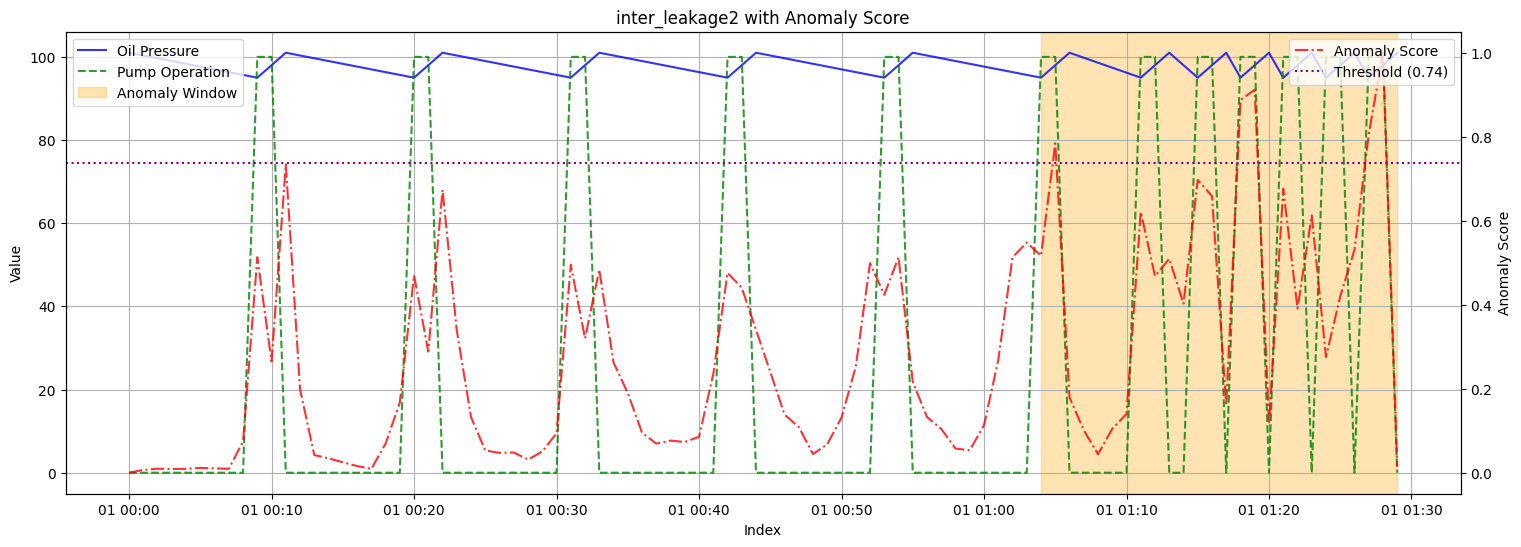

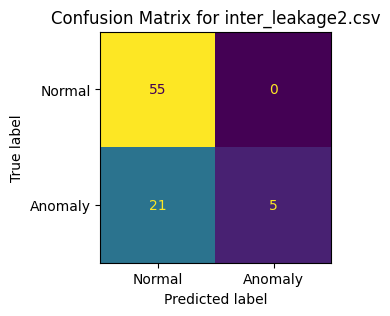

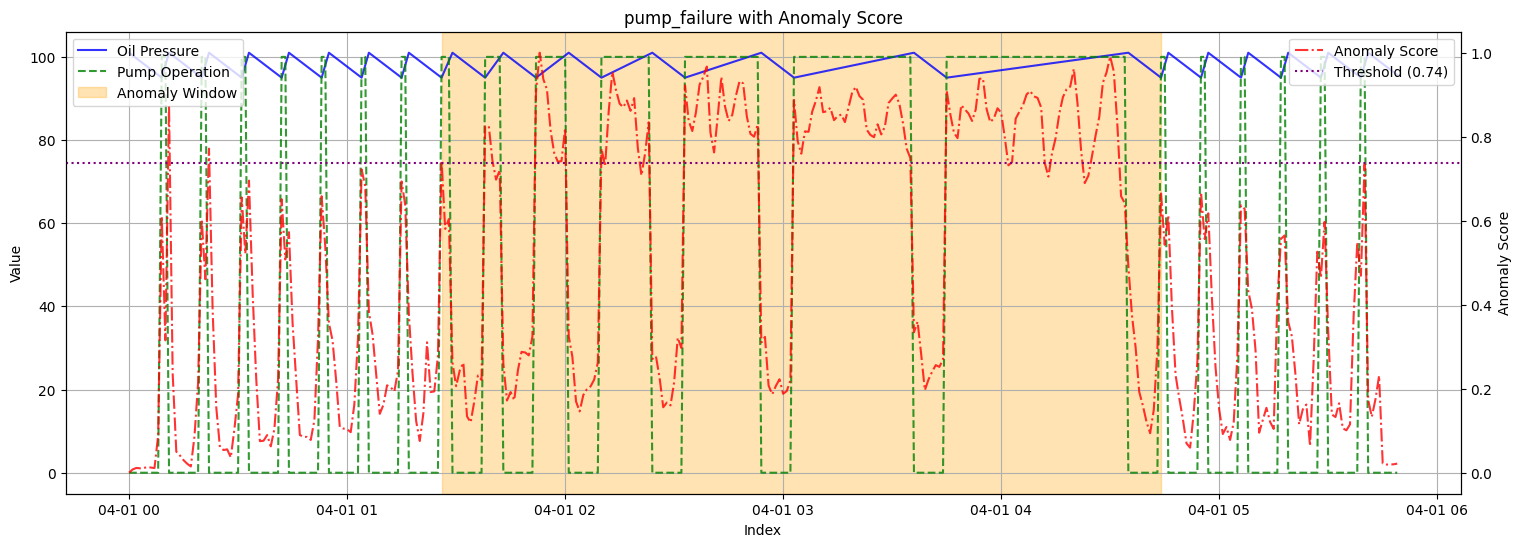

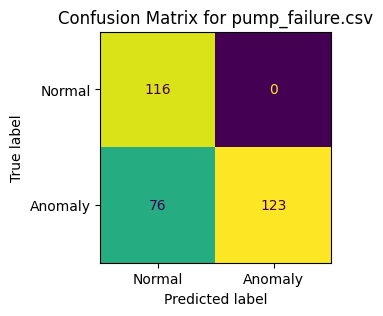

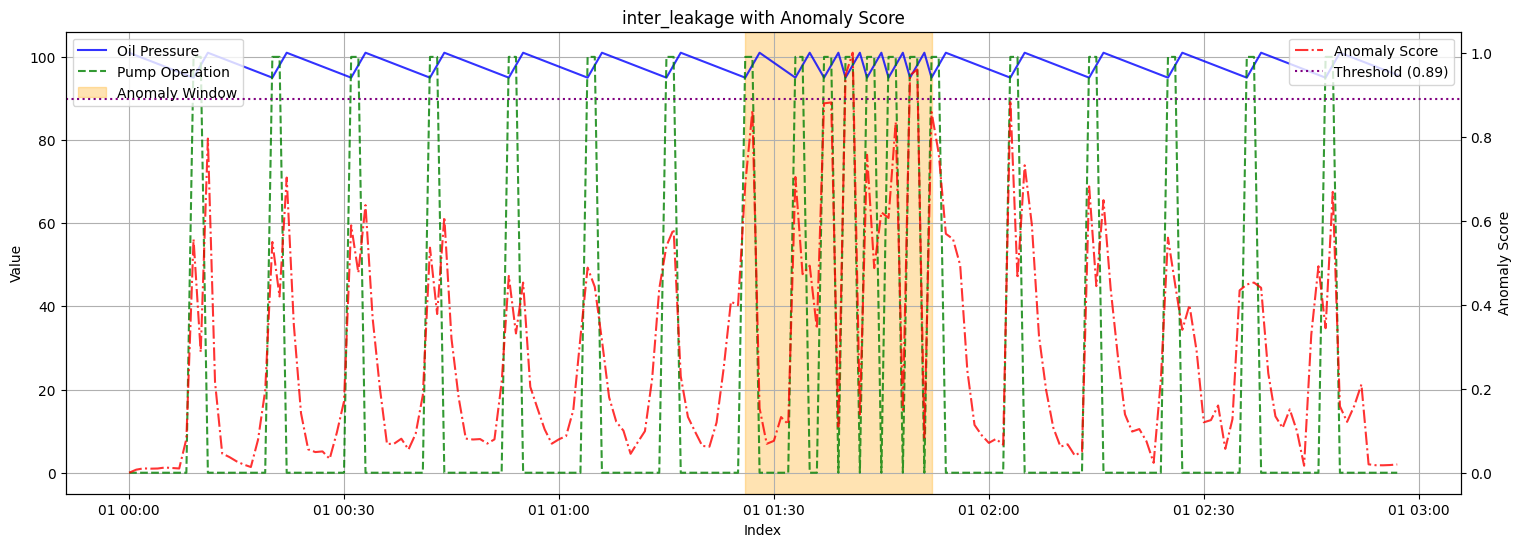

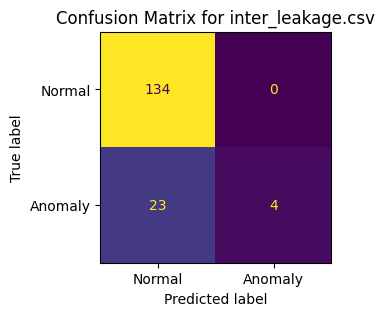

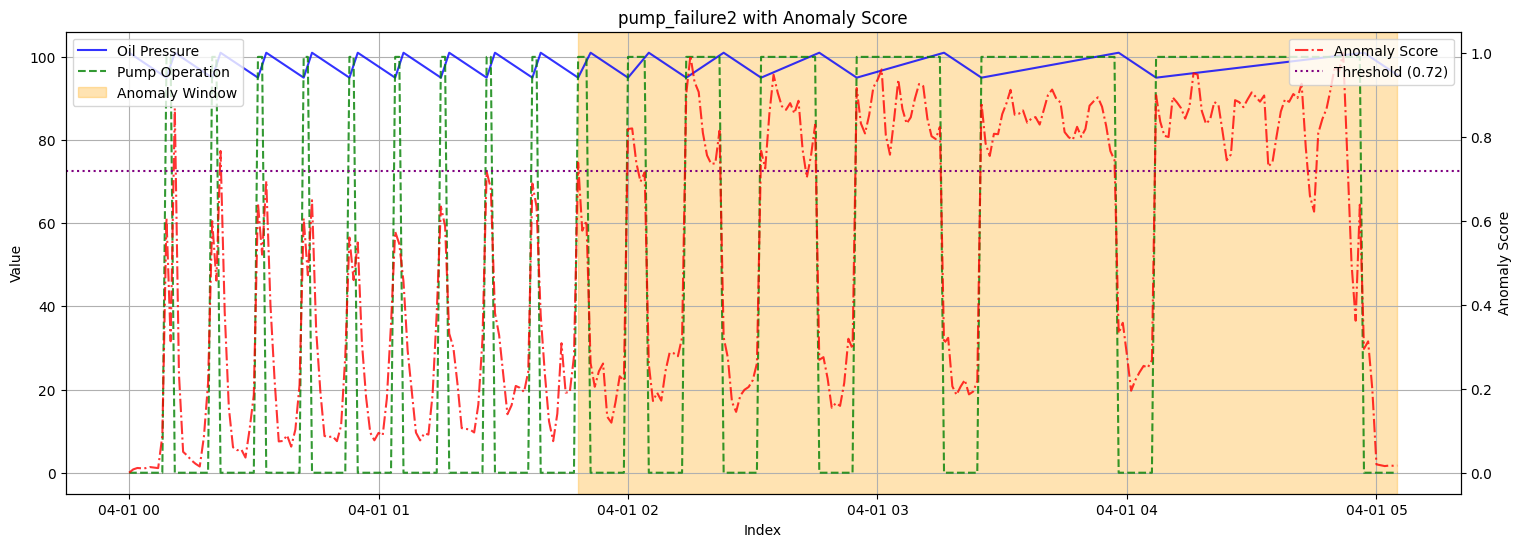

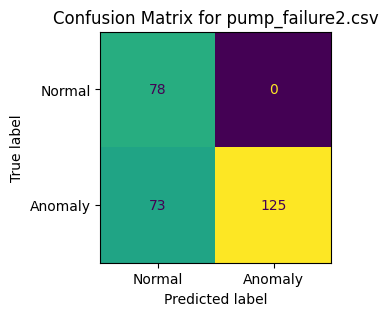

In [18]:
import NAB_scorer
importlib.reload(NAB_scorer)
from NAB_scorer import NABScorer

model_name = 'lstm_TL_u1'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

## Score lstm_TL_u2

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 90.27, 
            score=0.756830594195369, 
            threshold=0.3181818181818182, 
            TP=126, TN=78, FP=0, FN=72

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 95.41, 
            score=0.8851426312614474, 
            threshold=0.8363636363636363, 
            TP=5, TN=134, FP=0, FN=22

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 87.41, 
            score=0.6852657009019265, 
            threshold=0.8181818181818181, 
            TP=25, TN=116, FP=0, FN=174

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 93.63, 
            score=0.8407850447119221, 
            threshold=0.6363636363636364, 
            TP=8, TN=55, FP=0, FN=18

pump_failure2.csv: 90.27322376781477
inter_leakage.csv: 95.40570525045791
pump_failure.csv:

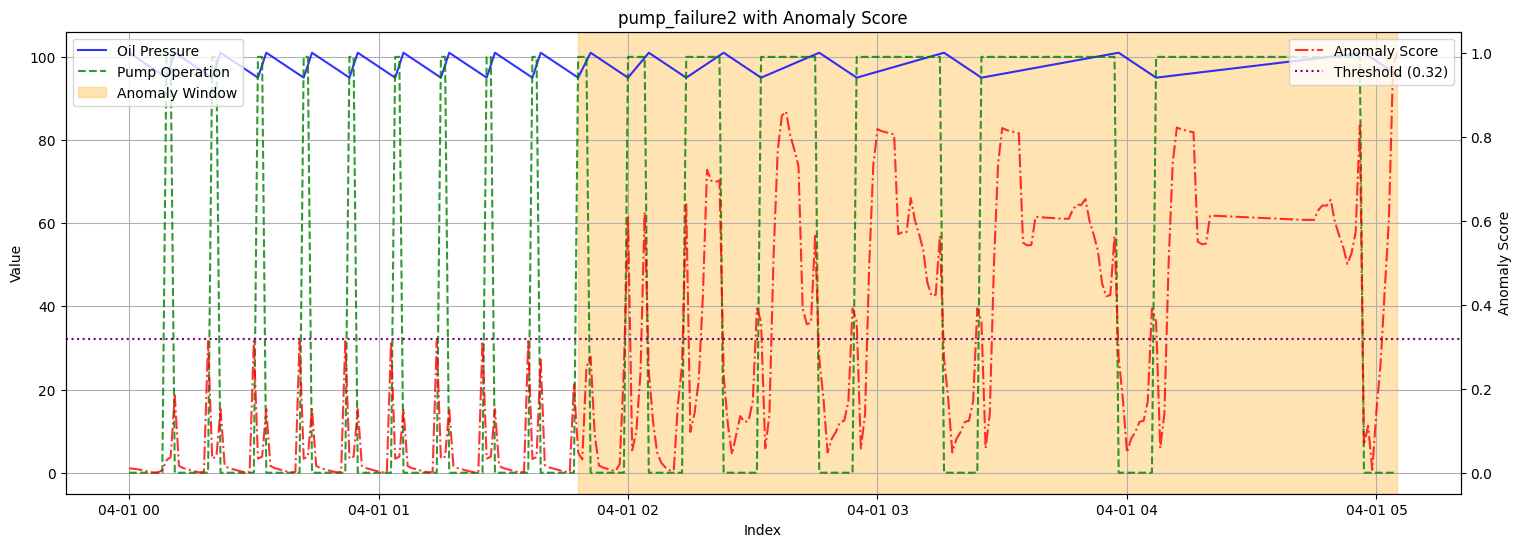

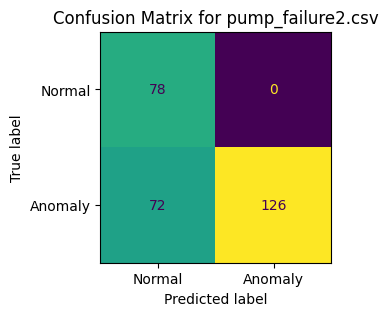

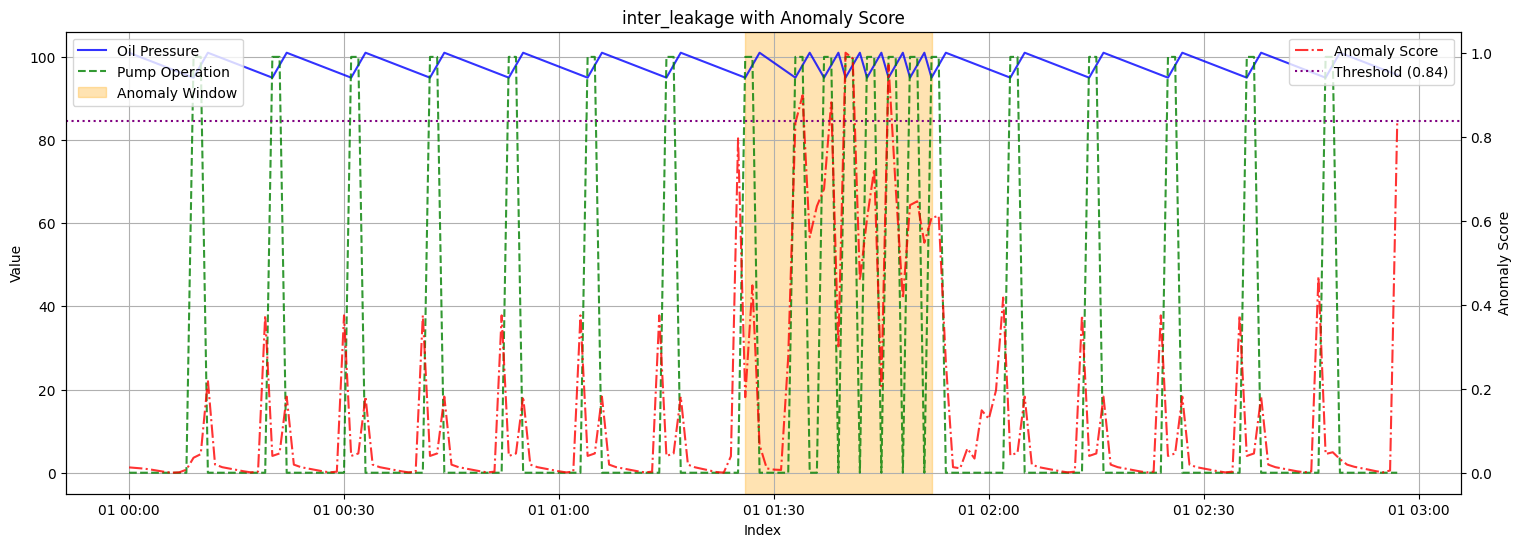

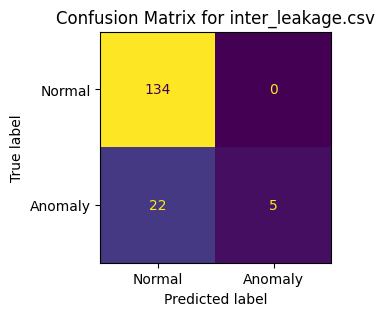

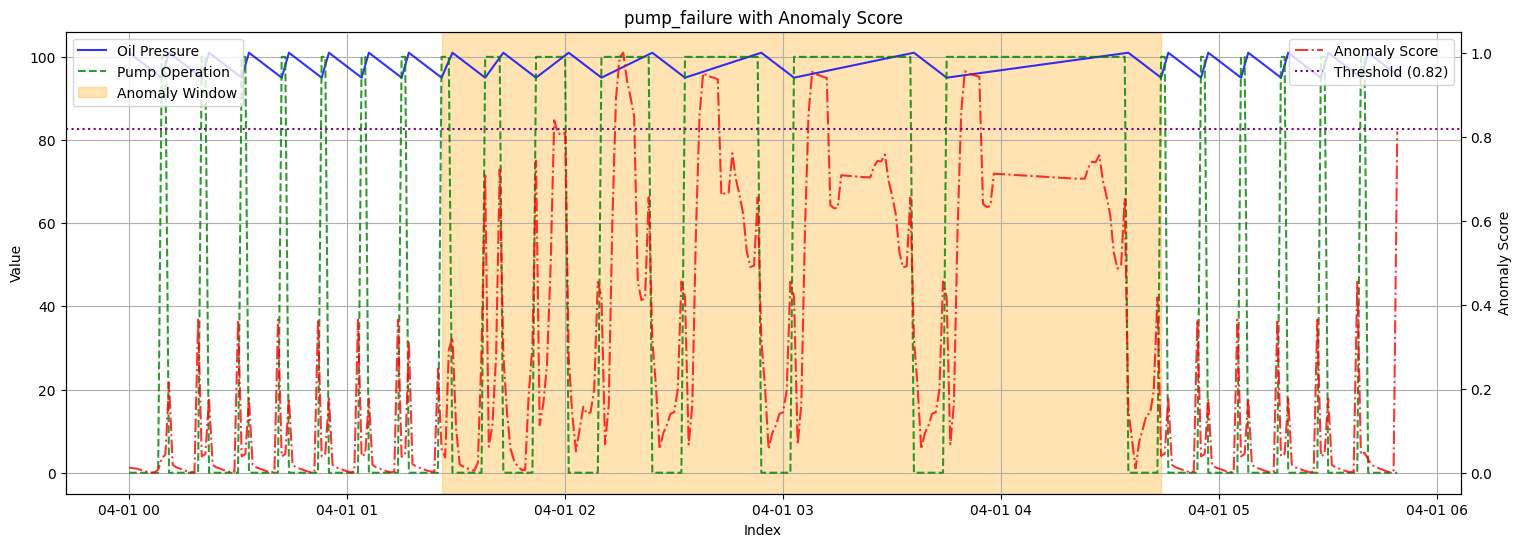

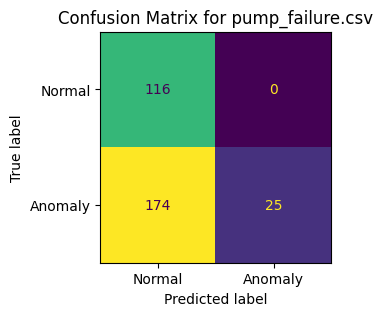

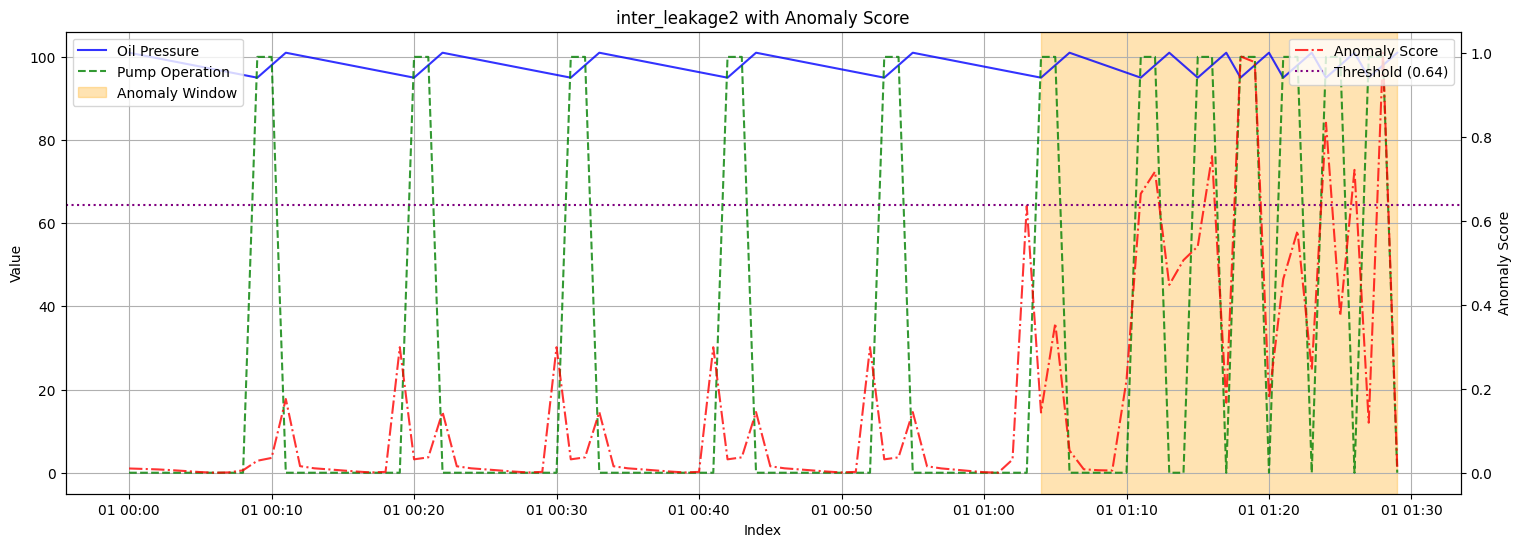

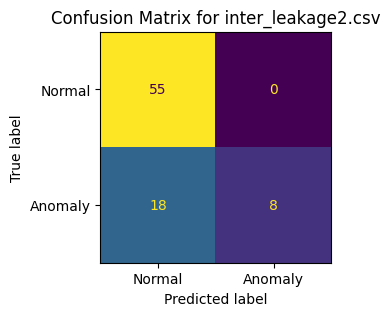

In [19]:
model_name = 'lstm_TL_u2'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

## Score lstm_small

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 92.67, 
            score=0.8168370460803791, 
            threshold=0.8363636363636363, 
            TP=3, TN=55, FP=0, FN=23

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 85.03, 
            score=0.6258327517429774, 
            threshold=0.9363636363636363, 
            TP=18, TN=116, FP=0, FN=181

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 88.81, 
            score=0.7203243034872335, 
            threshold=0.5181818181818182, 
            TP=103, TN=78, FP=0, FN=95

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 95.36, 
            score=0.8840897095572119, 
            threshold=0.8636363636363635, 
            TP=1, TN=134, FP=0, FN=26

inter_leakage2.csv: 92.67348184321517
pump_failure.csv: 85.03331006971908
pump_failure2.cs

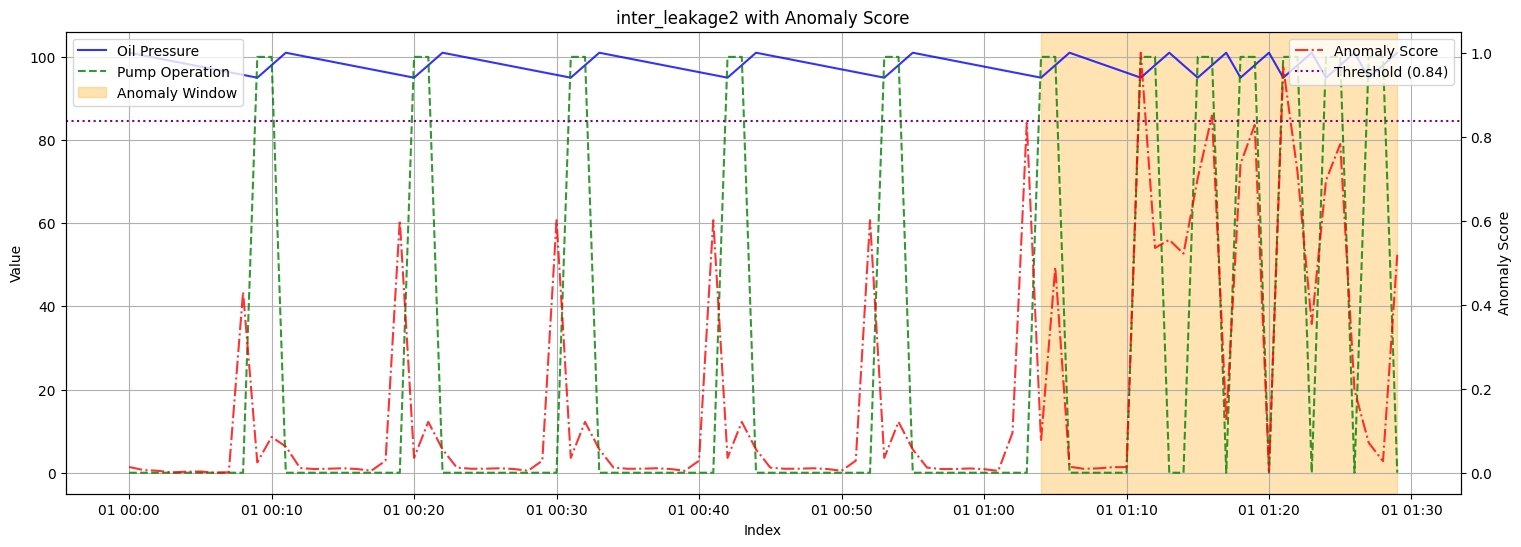

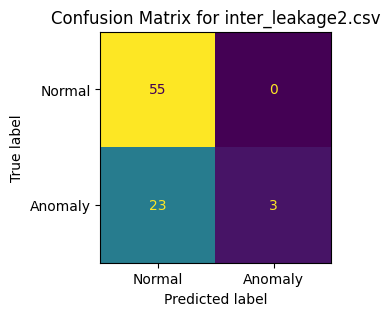

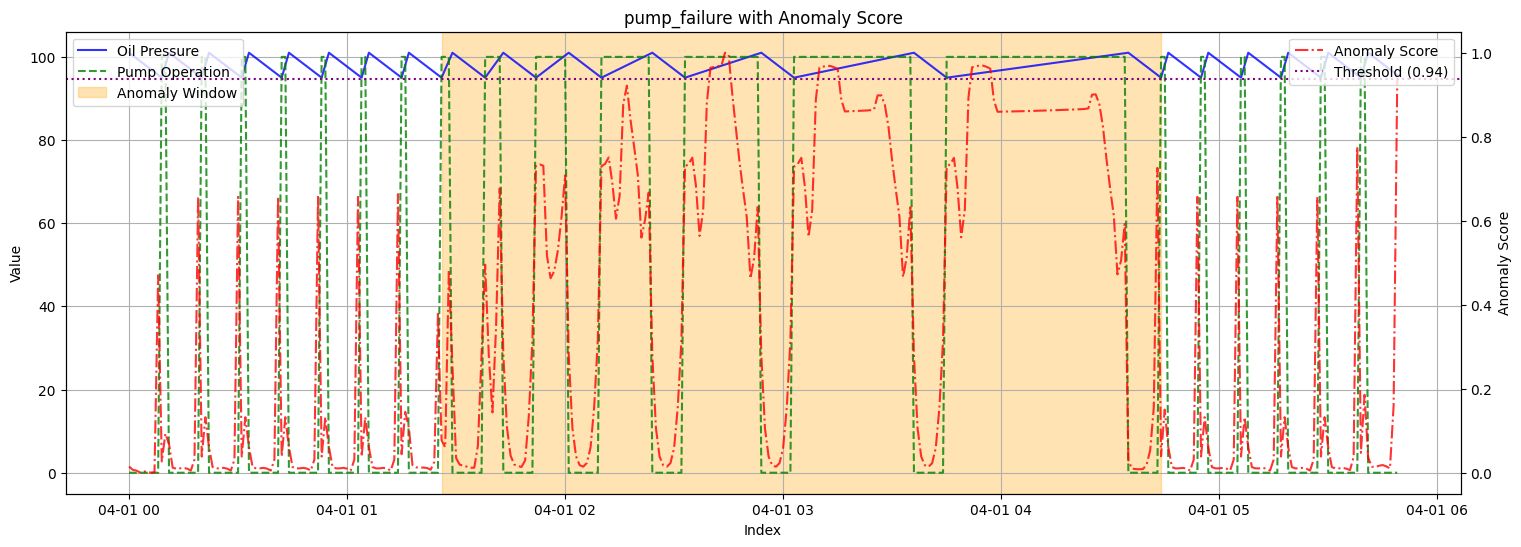

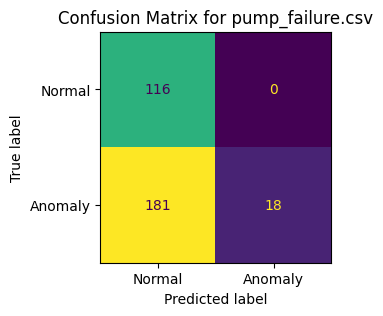

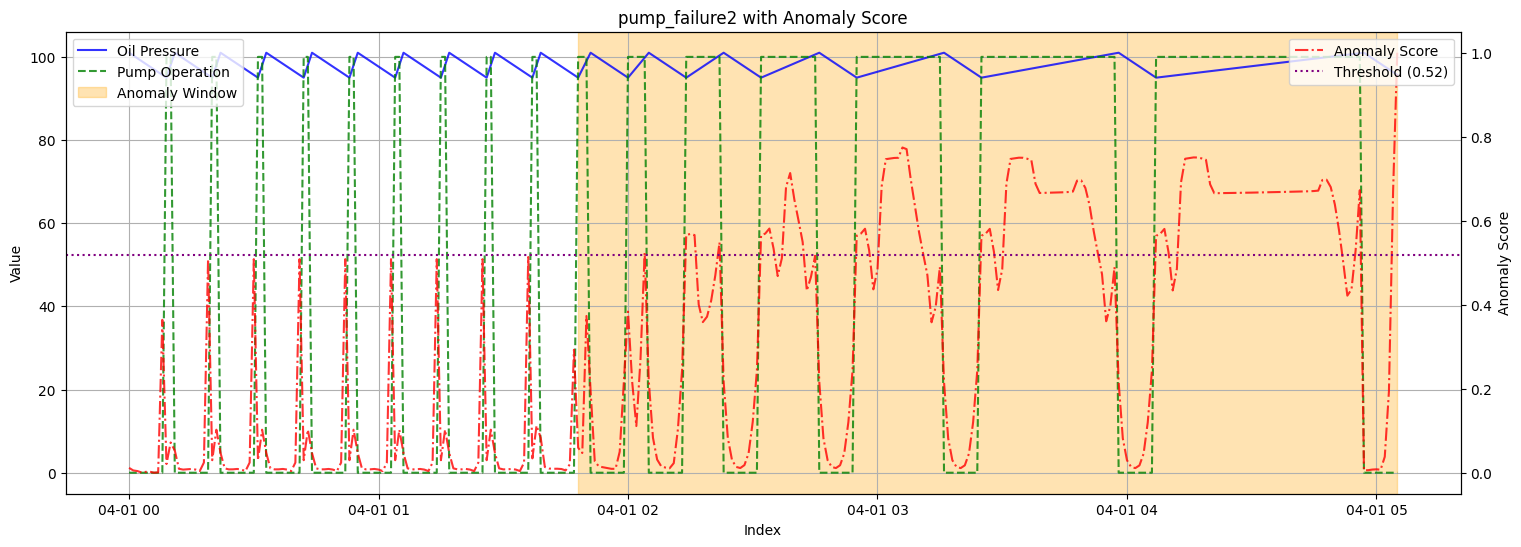

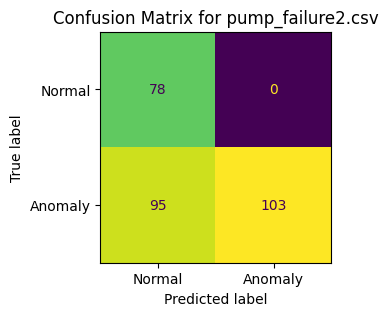

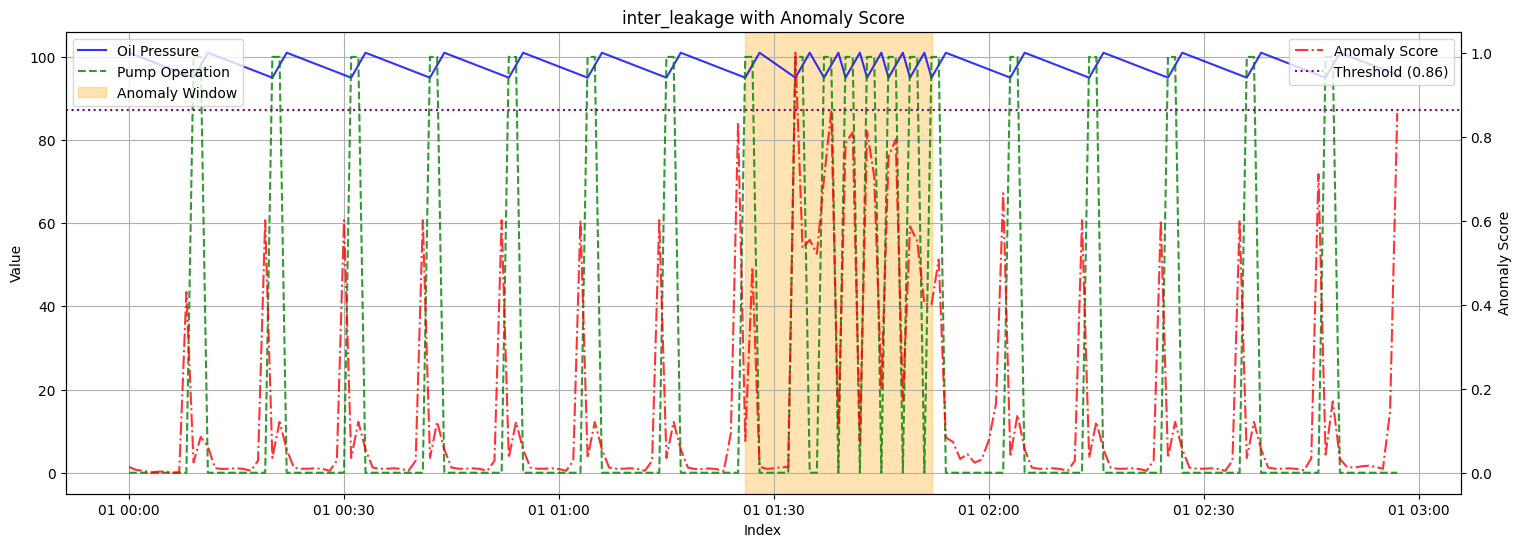

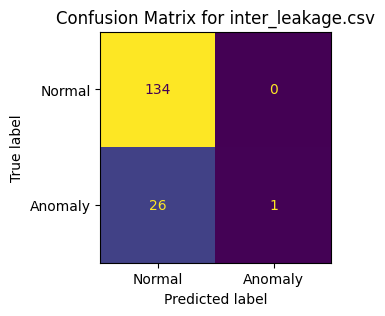

In [21]:
model_name = 'lstm_small'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

## Score lstm_TL_p2

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 88.69, 
            score=0.7172200452202961, 
            threshold=0.6636363636363636, 
            TP=105, TN=78, FP=0, FN=93

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 95.90, 
            score=0.8975273588644265, 
            threshold=0.7818181818181817, 
            TP=6, TN=134, FP=0, FN=21

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 96.97, 
            score=0.9242424242424242, 
            threshold=0.3727272727272727, 
            TP=16, TN=55, FP=0, FN=10

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 90.49, 
            score=0.7623013109374053, 
            threshold=0.6636363636363636, 
            TP=103, TN=116, FP=0, FN=96

pump_failure2.csv: 88.68880180881185
inter_leakage.csv: 95.90109435457705
inter_leakage2.

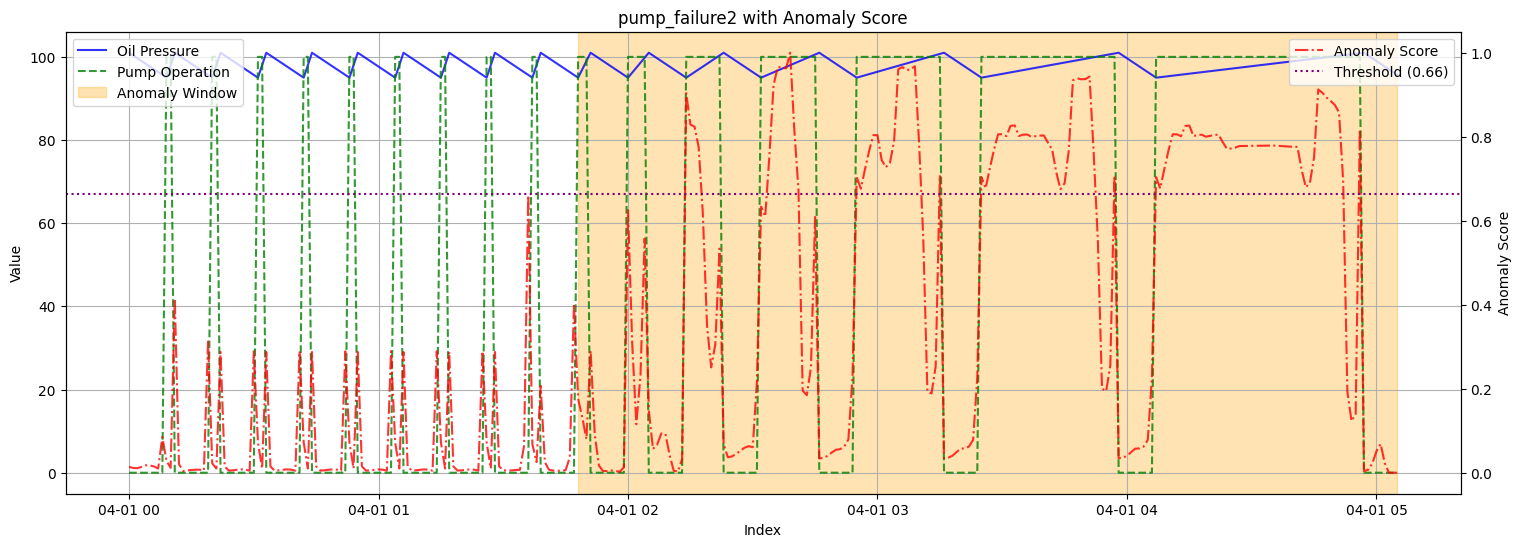

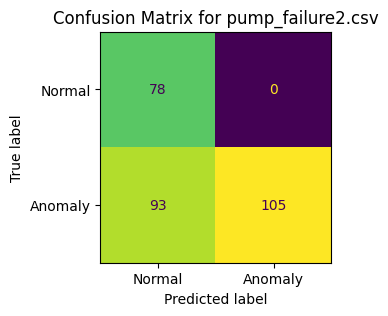

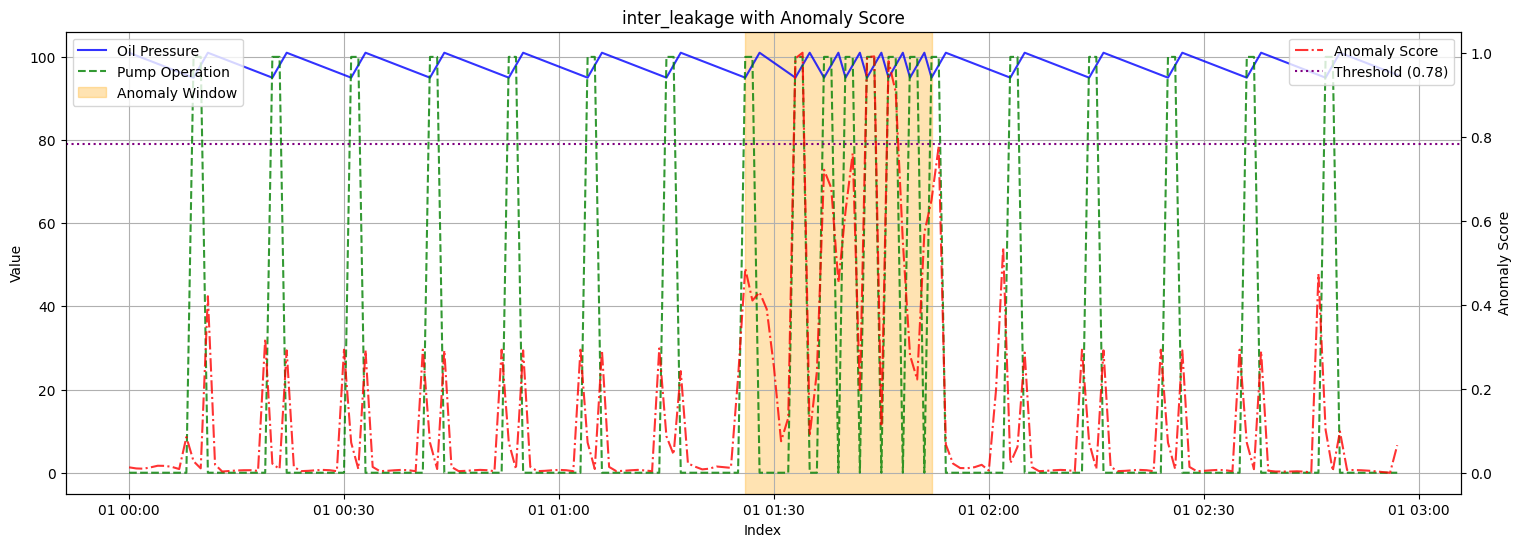

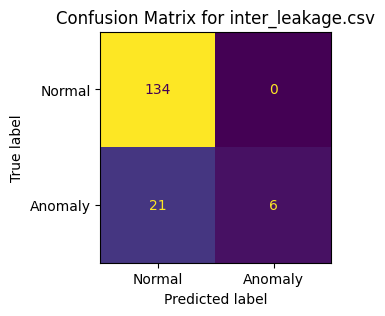

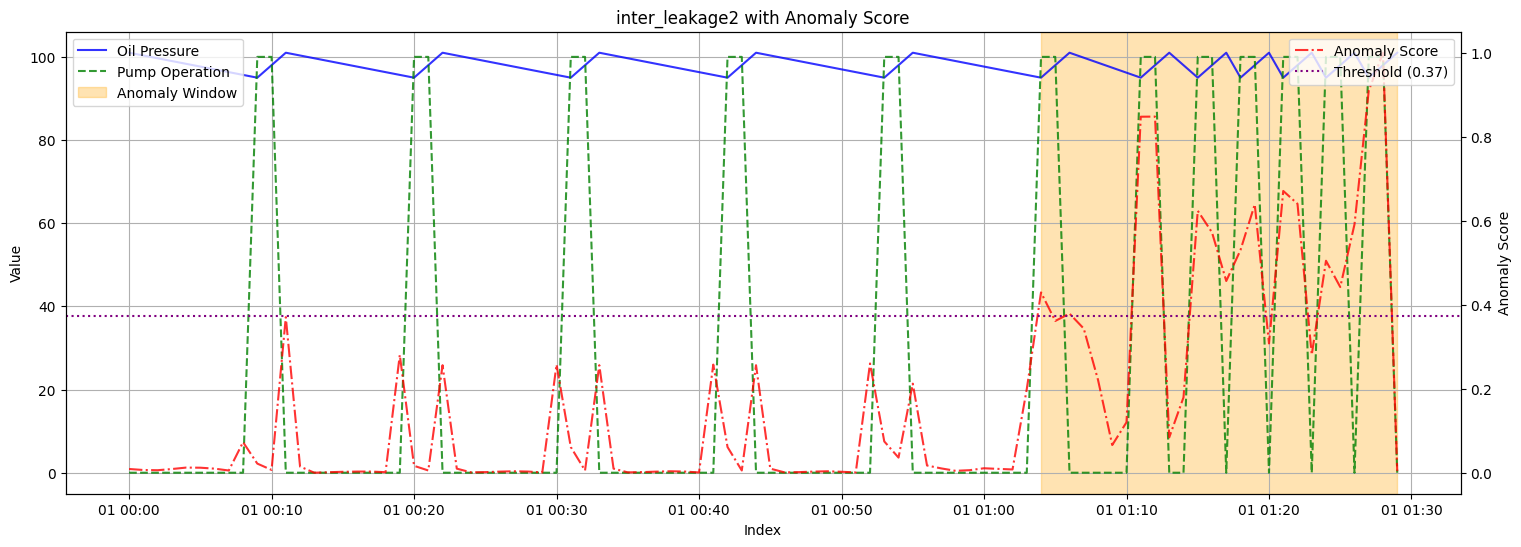

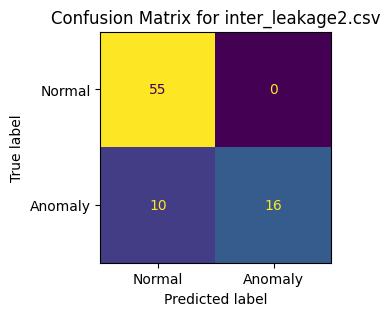

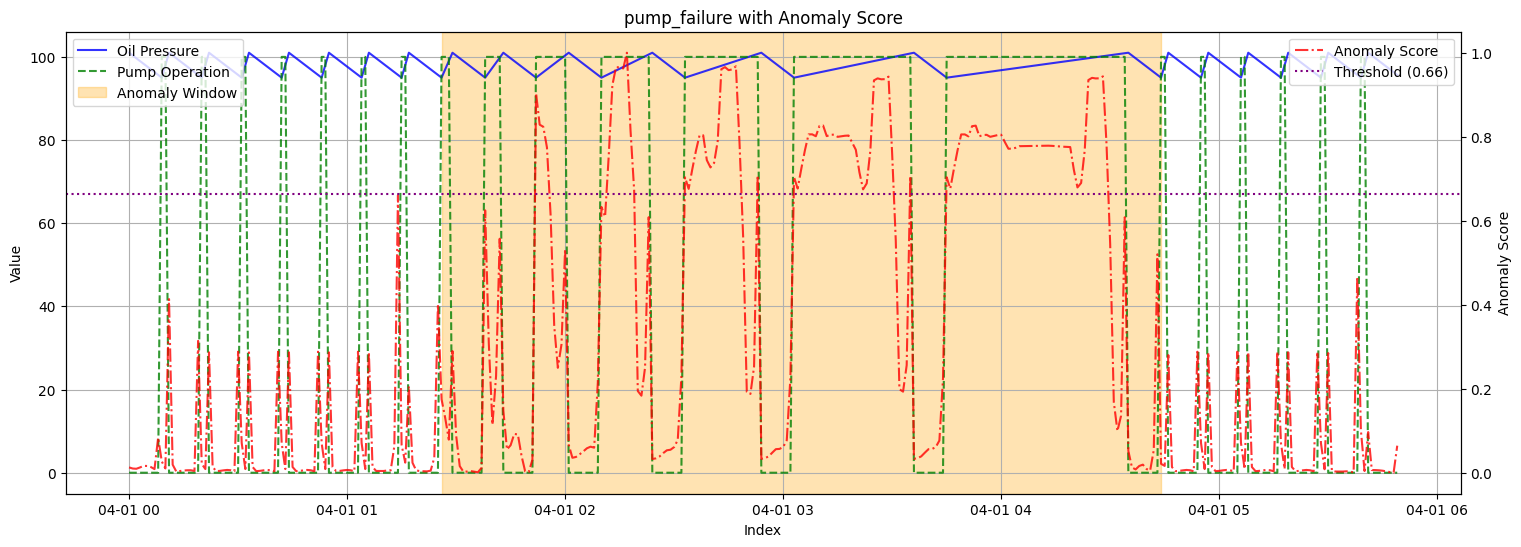

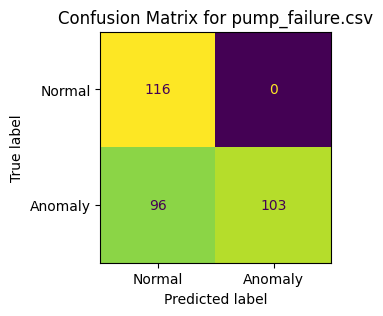

In [22]:
model_name = 'lstm_TL_p2'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

In [58]:
df_score = pd.DataFrame()
df_score.index = ['TL_u1', 'TL_u2', 'NoTL_small', 'TL_p2']
df_score['pump_failure'] = [score_u1['pump_failure.csv']['score'], score_u2['pump_failure.csv']['score'], score_small['pump_failure.csv']['score'], score_p2['pump_failure.csv']['score']]
df_score['inter_leakage'] = [score_u1['inter_leakage.csv']['score'], score_u2['inter_leakage.csv']['score'], score_small['inter_leakage.csv']['score'], score_p2['inter_leakage.csv']['score']]
df_score

pump_failure  inter_leakage
TL_u1          85.926909      95.084145
TL_u2          89.512400      97.535673
NoTL_small     84.451362      94.676053
TL_p2          88.012182      94.754193

In [ ]:
label_dict = json.load(open('../shf_labels.json'))

data_dict = {
    "pump_failure.csv": data1,
    "inter_leakage.csv": data2,
}

# Initialize scorer
scorer = NABScorer()

profiles = ["reward_low_FN_rate", "reward_low_FP_rate", "reward_low_FN_rate"]
scores = []

# Calculate scores
for p in profiles:
    scores.append(scorer.score(data_dict, label_dict, profile=p))
print('Final scores', scores)